#### The images are renamed and split into training ,testing and validation directories


#### Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Clean up all check points folder

In [0]:
!rm -rf ./data/black_measles/.ipynb_checkpoints
!rm -rf ./data/black_rot/.ipynb_checkpoints
!rm -rf ./data/leaf_blight/.ipynb_checkpoints
!rm -rf ./data/healthy/.ipynb_checkpoints
!rm -rf ./data/phylloxera/.ipynb_checkpoints

### Rename Image Files

The file names for each image are uniterpretable (e.g., 0a4403ee-995a-4dbd-add7-f13bf17e15dd___FAM_B.Msls 4248). The images are renamed therefore.

In [0]:
def rename_images(path, class_name):
  """
 Function to rename all images inside a directory to a standard
  naming scheme.
  @param path - the path to the image directory
  @param class_name - the name of the class
  """
  for i, image in enumerate(os.listdir(path)):
    new_name = class_name + str(i).zfill(4) + '.jpg'
    src = os.path.join(path, image)
    dst = os.path.join(path, new_name)
    os.rename(src, dst)
  print('Finished renaming all images.')

In [0]:
# Rename all images
rename_images(black_measles_dir, class_name='black_measles')
rename_images(black_rot_dir, class_name='black_rot')
rename_images(leaf_blight_dir, class_name='leaf_blight')
rename_images(phylloxera_dir, class_name='phylloxera')
rename_images(healthy_dir, class_name='healthy')

Finished renaming all images.
Finished renaming all images.
Finished renaming all images.
Finished renaming all images.
Finished renaming all images.


In [0]:
# Confirm
print(os.listdir(black_measles_dir)[:10])
print(os.listdir(black_rot_dir)[:10])
print(os.listdir(leaf_blight_dir)[:10])
print(os.listdir(phylloxera_dir)[:10])
print(os.listdir(healthy_dir)[:10])

['black_measles0206.jpg', 'black_measles0157.jpg', 'black_measles0365.jpg', 'black_measles0324.jpg', 'black_measles0297.jpg', 'black_measles0378.jpg', 'black_measles0099.jpg', 'black_measles0189.jpg', 'black_measles0212.jpg', 'black_measles0033.jpg']
['black_rot0102.jpg', 'black_rot0117.jpg', 'black_rot0265.jpg', 'black_rot0352.jpg', 'black_rot0299.jpg', 'black_rot0083.jpg', 'black_rot0343.jpg', 'black_rot0078.jpg', 'black_rot0247.jpg', 'black_rot0245.jpg']
['leaf_blight0141.jpg', 'leaf_blight0118.jpg', 'leaf_blight0121.jpg', 'leaf_blight0021.jpg', 'leaf_blight0145.jpg', 'leaf_blight0148.jpg', 'leaf_blight0119.jpg', 'leaf_blight0128.jpg', 'leaf_blight0329.jpg', 'leaf_blight0025.jpg']
['phylloxera0166.jpg', 'phylloxera0033.jpg', 'phylloxera0161.jpg', 'phylloxera0081.jpg', 'phylloxera0110.jpg', 'phylloxera0240.jpg', 'phylloxera0235.jpg', 'phylloxera0169.jpg', 'phylloxera0189.jpg', 'phylloxera0366.jpg']
['healthy0292.jpg', 'healthy0281.jpg', 'healthy0213.jpg', 'healthy0169.jpg', 'healthy0

#### Import Packages

In [0]:
from __future__ import (absolute_import, 
                        division, 
                        print_function, 
                        unicode_literals)

import os
import cv2
import glob
import time
import math
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import pylab
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import tensorflow as tf
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set random seed for consistency
random.seed(100)
np.random.seed(100)
tf.set_random_seed(100)

# Displays all outputs of a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 5]

print('TensorFlow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow version: 1.15.2
Keras version: 2.2.4-tf


## Define Directory Paths

The dataset has to be organized in a way such that the model is able to recognize the test and train data and the different classes. The training data is used to train the model, through which the model learns various features of the images and learns to recognize and classify different images.
Test data is the data unseen by the model. The model makes predictions on the test images and it's performance is quantified based on how many test images are predicted right.

In [0]:
work_dir = '.'
data_dir = os.path.join(work_dir, 'data')
data_arr_dir = os.path.join(work_dir, 'data_arr')
model_dir = os.path.join(work_dir, 'saved_models')

# Original data (before split)
black_measles_dir = os.path.join(data_dir, 'black_measles')
black_rot_dir = os.path.join(data_dir, 'black_rot')
leaf_blight_dir = os.path.join(data_dir, 'leaf_blight')
phylloxera_dir = os.path.join(data_dir, 'phylloxera')
healthy_dir = os.path.join(data_dir, 'healthy')


# Train/Validation/Test
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# Training data by class
train_black_measles_dir = os.path.join(train_dir, 'black_measles')
train_black_rot_dir = os.path.join(train_dir, 'black_rot')
train_leaf_blight_dir = os.path.join(train_dir, 'leaf_blight')
train_phylloxera_dir = os.path.join(train_dir, 'phylloxera')
train_healthy_dir = os.path.join(train_dir, 'healthy')

# Validation data by class
validation_black_measles_dir = os.path.join(validation_dir, 'black_measles')
validation_black_rot_dir = os.path.join(validation_dir, 'black_rot')
validation_leaf_blight_dir = os.path.join(validation_dir, 'leaf_blight')
validation_phylloxera_dir = os.path.join(validation_dir, 'phylloxera')
validation_healthy_dir = os.path.join(validation_dir, 'healthy')

# Test data by class
test_black_measles_dir = os.path.join(test_dir, 'black_measles')
test_black_rot_dir = os.path.join(test_dir, 'black_rot')
test_leaf_blight_dir = os.path.join(test_dir, 'leaf_blight')
test_phylloxera_dir = os.path.join(test_dir, 'phylloxera')
test_healthy_dir = os.path.join(test_dir, 'healthy')

In [0]:
if not os.path.exists(data_dir):
  os.mkdir(data_dir)
if not os.path.exists(data_arr_dir):
  os.mkdir(data_arr_dir)
if not os.path.exists(model_dir):
  os.mkdir(model_dir)

os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

os.mkdir(train_black_measles_dir)
os.mkdir(train_black_rot_dir)
os.mkdir(train_leaf_blight_dir)
os.mkdir(train_phylloxera_dir)
os.mkdir(train_healthy_dir)

os.mkdir(validation_black_measles_dir)
os.mkdir(validation_black_rot_dir)
os.mkdir(validation_leaf_blight_dir)
os.mkdir(validation_phylloxera_dir)
os.mkdir(validation_healthy_dir)

os.mkdir(test_black_measles_dir)
os.mkdir(test_black_rot_dir)
os.mkdir(test_leaf_blight_dir)
os.mkdir(test_phylloxera_dir)
os.mkdir(test_healthy_dir)

###  Dataset construction

#### Number of Images Per Class

In [0]:
num_black_measles = len(os.listdir(black_measles_dir))
num_black_rot = len(os.listdir(black_rot_dir))
num_leaf_blight = len(os.listdir(leaf_blight_dir))
num_phylloxera = len(os.listdir(phylloxera_dir))
num_healthy = len(os.listdir(healthy_dir))
total_images = num_black_measles + num_black_rot + num_leaf_blight + num_healthy+num_phylloxera
                                   
print('Total Images: {}'.format(total_images))
print('black_measles class has {} images'.format(num_black_measles))
print('black_rot class has {} images'.format(num_black_rot))
print('leaf_blight class has {} images'.format(num_leaf_blight))
print('phylloxera class has {} images'.format(num_phylloxera))
print('healthy class has {} images'.format(num_healthy))

Total Images: 5937
black_measles class has 1325 images
black_rot class has 1165 images
leaf_blight class has 1076 images
phylloxera class has 1220 images
healthy class has 1151 images


### Shuffle and Train-Validation-Test Split

A stratified split is done using the following function

80% for data is allocated for training and 20% for test. Then the training set is split into 80% training and 20% validation.

In [0]:
def split_data(data_src, label, test_size=0.2, val_size=0.2):
  '''
  Function to split the original dataset into training, validation, and test
  sets and copies to the respective folders. 
  @param data_src - the path to the data
  @param label - the class label
  @test_size - the percent allocated for test 
  @val_size - the percent allocated for validation (of the training data)
  '''
  assert label in ['black_measles', 'black_rot', 'leaf_blight', 'phylloxera', 'healthy'], \
    "Make sure class label is correct"
  
  train_dir = os.path.join(data_src, 'train', label)
  val_dir = os.path.join(data_src, 'validation', label)
  test_dir = os.path.join(data_src, 'test', label)
  
  assert len(os.listdir(train_dir)) == 0, "Training directory is not empty."
  assert len(os.listdir(val_dir)) == 0, "Validation directory is not empty."
  assert len(os.listdir(test_dir)) == 0, "Test directory is not empty."
  
  data_path = os.path.join(data_src, label)
  num_examples = len(os.listdir(data_path))
  
  # Shuffle the data
  datafiles = os.listdir(data_path)
  random.shuffle(datafiles)
  
  # Train-test split
  num_test = math.floor(num_examples*0.2)
  num_train = num_examples - num_test
  
  # Train-validation split
  num_val = math.floor(num_train*0.2)
  num_train = num_train - num_val
  
  # Train, validation, and test data
  train_files = datafiles[:num_train]
  val_files = datafiles[num_train:num_train+num_val]
  test_files = datafiles[num_train+num_val:]
    
  # Copy training data
  for filename in train_files:
    src = os.path.join(data_src, label, filename)
    dst = os.path.join(train_dir, filename)
    shutil.copyfile(src, dst)
    
  # Copy validation data
  for filename in val_files:
    src = os.path.join(data_src, label, filename)
    dst = os.path.join(val_dir, filename)
    shutil.copyfile(src, dst)
    
  # Copy test data
  for filename in test_files:
    src = os.path.join(data_src, label,filename)
    dst = os.path.join(test_dir, filename)
    shutil.copyfile(src, dst)

In [0]:
for label in ['black_measles', 'black_rot', 'leaf_blight', 'phylloxera', 'healthy']:
  split_data(data_dir, label) #partition the dataset in a stratified fashion and copy the images to their respective folders.

In [0]:
#check the number of data in each folder
num_train_black_measles = len(os.listdir(train_black_measles_dir))
num_train_black_rot = len(os.listdir(train_black_rot_dir))
num_train_leaf_blight = len(os.listdir(train_leaf_blight_dir))
num_train_phylloxera = len(os.listdir(train_phylloxera_dir))
num_train_healthy = len(os.listdir(train_healthy_dir))

num_val_black_measles = len(os.listdir(validation_black_measles_dir))
num_val_black_rot = len(os.listdir(validation_black_rot_dir))
num_val_leaf_blight = len(os.listdir(validation_leaf_blight_dir))
num_val_phylloxera = len(os.listdir(validation_phylloxera_dir))
num_val_healthy = len(os.listdir(validation_healthy_dir))

num_test_black_measles = len(os.listdir(test_black_measles_dir))
num_test_black_rot = len(os.listdir(test_black_rot_dir))
num_test_leaf_blight = len(os.listdir(test_leaf_blight_dir))
num_test_phylloxera = len(os.listdir(test_phylloxera_dir))
num_test_healthy = len(os.listdir(test_healthy_dir))

total_train = num_train_black_measles + num_train_black_rot + \
                num_train_leaf_blight + num_train_phylloxera + num_train_healthy
total_val = num_val_black_measles + num_val_black_rot + \
              num_val_leaf_blight + num_val_phylloxera + num_val_healthy
total_test = num_test_black_measles + num_test_black_rot + \
              num_test_leaf_blight + num_test_phylloxera + num_test_healthy

def check_distribution(total, black_measles, black_rot, leaf_blight, phylloxera, healthy):
  print('% of black_measles: {:.2f}%'.format((black_measles/total)*100.0))
  print('% of blacK_rot: {:.2f}%'.format((black_rot / total)*100))
  print('% of leaf_blight: {:.2f}%'.format((leaf_blight / total)*100.0))
  print('% of phylloxera: {:.2f}%'.format((phylloxera / total)*100.0))
  print('% of healthy: {:.2f}%'.format((healthy / total)*100.0))
  print()
  
print('Total images:', total_train + total_val + total_test)
print('Total black_measles:', num_train_black_measles+num_val_black_measles+num_test_black_measles)
print('Total blacK_rot:', num_train_black_rot+num_val_black_rot+num_test_black_rot)
print('Total leaf_blight:', num_train_leaf_blight+num_val_leaf_blight+num_test_leaf_blight)
print('Total phylloxera:', num_train_phylloxera+num_val_phylloxera+num_test_phylloxera)
print('Total healthy:', num_train_healthy+num_val_healthy+num_test_healthy)
print()
print('Number of black_measles training images:', num_train_black_measles)
print('Number of black_rot training images:', num_train_black_rot)
print('Number of leaf_blight training images:', num_train_leaf_blight)
print('Number of phylloxera training images:', num_train_phylloxera)
print('Number of healthy training images:', num_train_healthy)
print()
print('Number of black_measles validation images:', num_val_black_measles)
print('Number of black_rot validation images:', num_val_black_rot)
print('Number of leaf_blight validation images:', num_val_leaf_blight)
print('Number of phylloxera validation images:', num_val_phylloxera)
print('Number of healthy validation images:', num_val_healthy)
print()
print('Number of black_measles test images:', num_test_black_measles)
print('Number of black_rot test images:', num_test_black_rot)
print('Number of leaf_blight test images:', num_test_leaf_blight)
print('Number of phylloxera test images:', num_test_phylloxera)
print('Number of healthy test images:', num_test_healthy)
print()
print('Training distribution')
check_distribution(total_train, num_train_black_measles, num_train_black_rot,
                    num_train_leaf_blight, num_train_phylloxera, num_train_healthy)
print('Validation distribution')
check_distribution(total_val, num_val_black_measles, num_val_black_rot,
                    num_val_leaf_blight, num_val_phylloxera, num_val_healthy)
print('Test distribution')
check_distribution(total_test, num_test_black_measles, num_test_black_rot,
                    num_test_leaf_blight, num_test_phylloxera, num_test_healthy)


Total images: 5937
Total black_measles: 1325
Total blacK_rot: 1165
Total leaf_blight: 1076
Total phylloxera: 1220
Total healthy: 1151

Number of black_measles training images: 848
Number of black_rot training images: 746
Number of leaf_blight training images: 689
Number of phylloxera training images: 781
Number of healthy training images: 737

Number of black_measles validation images: 212
Number of black_rot validation images: 186
Number of leaf_blight validation images: 172
Number of phylloxera validation images: 195
Number of healthy validation images: 184

Number of black_measles test images: 265
Number of black_rot test images: 233
Number of leaf_blight test images: 215
Number of phylloxera test images: 244
Number of healthy test images: 230

Training distribution
% of black_measles: 22.31%
% of blacK_rot: 19.63%
% of leaf_blight: 18.13%
% of phylloxera: 20.55%
% of healthy: 19.39%

Validation distribution
% of black_measles: 22.34%
% of blacK_rot: 19.60%
% of leaf_blight: 18.12%


### Observe Example Images

In [0]:
def read_img(filepath, size):
  """
  Helper function to convert an image into a Numpy array.
  @param filepath - path to the image
  @param size - size to resize the image to
  """
  img = image.load_img(filepath, target_size=size)
  img = image.img_to_array(img)
  return img

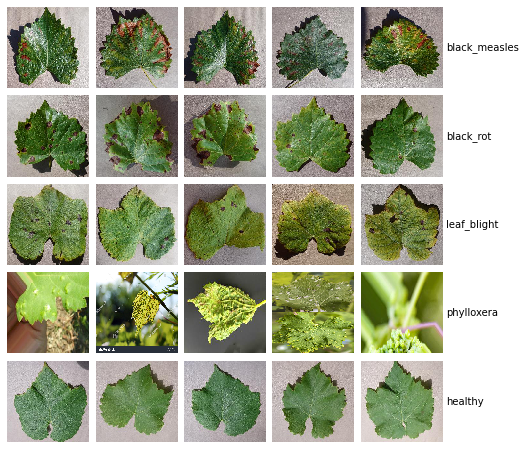

In [0]:
CATEGORIES = ['black_measles', 'black_rot', 'leaf_blight', 'phylloxera', 'healthy']
NUM_CATEGORIES = len(CATEGORIES)
height, width = 256, 256

# Create image grid
fig = plt.figure(num=1, figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES,NUM_CATEGORIES),
                 axes_pad=0.1) # pad between axes in inch.

# Plot each example image per grid square
i = 0
for category in CATEGORIES:
  for j in range(5):
    ax = grid[i]
    path = os.path.join(data_dir, category)
    file = category + str(j).zfill(4) + '.jpg'
    img = read_img(os.path.join(path, file), size=(height, width))
    ax.imshow(img/255., interpolation='nearest', aspect='auto')
    ax.axis('off')
    if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
      ax.text(x=height*1.05, y=height//2, s=category, verticalalignment='center')
    i += 1

fig.show();